In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load and prepare data
def load_data():
    customers = pd.read_csv('Customers.csv')
    products = pd.read_csv('Products.csv')
    transactions = pd.read_csv('Transactions.csv')
    
    # Convert dates to datetime
    customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
    transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
    
    return customers, products, transactions



In [3]:
def create_customer_features(customers, transactions):
    # Calculate customer metrics
    customer_metrics = transactions.groupby('CustomerID').agg({
        'TransactionID': 'count',  # Number of transactions
        'TotalValue': 'sum',      # Total spend
        'Quantity': 'sum',        # Total items bought
        'ProductID': 'nunique'    # Unique products bought
    }).reset_index()
    
    customer_metrics.columns = ['CustomerID', 'Transaction_Count', 'Total_Spend', 
                              'Total_Items', 'Unique_Products']
    
    # Calculate average order value
    customer_metrics['Avg_Order_Value'] = customer_metrics['Total_Spend'] / customer_metrics['Transaction_Count']
    
    # Calculate customer lifetime (days since signup)
    customers['Customer_Lifetime'] = (datetime.now() - customers['SignupDate']).dt.days
    
    # Merge customer profile with transaction metrics
    customer_features = customers.merge(customer_metrics, on='CustomerID')
    
    return customer_features



In [4]:
def prepare_for_clustering(customer_features):
    # Select features for clustering
    clustering_features = ['Customer_Lifetime', 'Transaction_Count', 'Total_Spend', 
                         'Total_Items', 'Unique_Products', 'Avg_Order_Value']
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(customer_features[clustering_features])
    
    return X, clustering_features



In [5]:
def find_optimal_clusters(X, max_clusters=10):
    db_scores = []
    silhouette_scores = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X)
        
        # Calculate Davies-Bouldin score
        db_score = davies_bouldin_score(X, labels)
        db_scores.append(db_score)
        
        # Calculate Silhouette score
        sil_score = silhouette_score(X, labels)
        silhouette_scores.append(sil_score)
    
    # Plot both scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Davies-Bouldin Score plot
    ax1.plot(range(2, max_clusters + 1), db_scores, marker='o', color='blue', linewidth=2)
    ax1.set_title('Davies-Bouldin Score vs Number of Clusters')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Davies-Bouldin Score')
    ax1.grid(True)
    # Add point marker for optimal number of clusters
    optimal_clusters = np.argmin(db_scores) + 2
    ax1.scatter(optimal_clusters, min(db_scores), color='red', s=100, 
                label=f'Optimal clusters: {optimal_clusters}')
    ax1.legend()
    
    # Silhouette Score plot
    ax2.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', color='green', linewidth=2)
    ax2.set_title('Silhouette Score vs Number of Clusters')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.grid(True)
    # Add point marker for maximum silhouette score
    max_sil_clusters = np.argmax(silhouette_scores) + 2
    ax2.scatter(max_sil_clusters, max(silhouette_scores), color='red', s=100,
                label=f'Max score at: {max_sil_clusters}')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('Number of Clusters')
    plt.show()
    
    # Find optimal number of clusters using only DB Index
    optimal_clusters = np.argmin(db_scores) + 2
    
    return optimal_clusters, db_scores, silhouette_scores

In [6]:
def visualize_clusters(customer_features, labels, clustering_features):
    # Add cluster labels to the dataset
    customer_features['Cluster'] = labels
    
    # Create PCA visualization
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(StandardScaler().fit_transform(customer_features[clustering_features]))
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')
    plt.title('Customer Segments Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter)
    plt.savefig('Customer Segments Visualization (PCA)')
    plt.show()
    
    # Create feature distributions by cluster
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    
    for idx, feature in enumerate(clustering_features):
        sns.boxplot(data=customer_features, x='Cluster', y=feature, ax=axes[idx])
        axes[idx].set_title(f'{feature} by Cluster')
    
    plt.tight_layout()
    plt.savefig('Box Plot')
    plt.show()
    
    return customer_features

In [7]:
def generate_cluster_report(customer_features, db_score, silhouette_score):
    print("Customer Segmentation Report")
    print("===========================")
    print(f"\nNumber of Clusters: {customer_features['Cluster'].nunique()}")
    print(f"Davies-Bouldin Index: {db_score:.4f} (used for optimal cluster selection)")
    print(f"Silhouette Score: {silhouette_score:.4f} (for reference only)")
    
    print("\nCluster Sizes:")
    print(customer_features['Cluster'].value_counts().sort_index())
    
    print("\nCluster Profiles:")
    cluster_profiles = customer_features.groupby('Cluster')[['Customer_Lifetime', 'Transaction_Count', 
                                                           'Total_Spend', 'Total_Items', 
                                                           'Unique_Products', 'Avg_Order_Value']].mean()
    print(cluster_profiles.round(2))

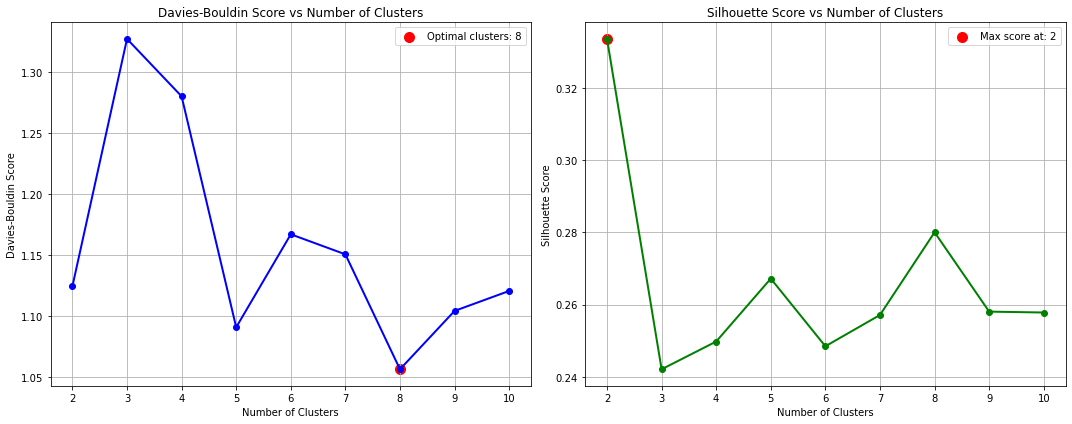

In [8]:
# Load data
customers, products, transactions = load_data()
    
# Create customer features
customer_features = create_customer_features(customers, transactions)
    
# Prepare data for clustering
X, clustering_features = prepare_for_clustering(customer_features)
    
# Find optimal number of clusters
optimal_clusters, db_scores, silhouette_scores = find_optimal_clusters(X)
    
# Perform clustering with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
labels = kmeans.fit_predict(X)
    
# Calculate final DB Index
final_db_score = davies_bouldin_score(X, labels)
final_silhouette_score = silhouette_score(X, labels)    


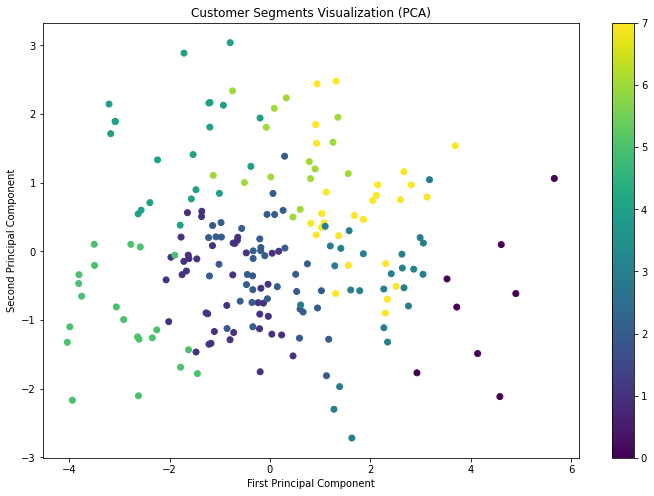

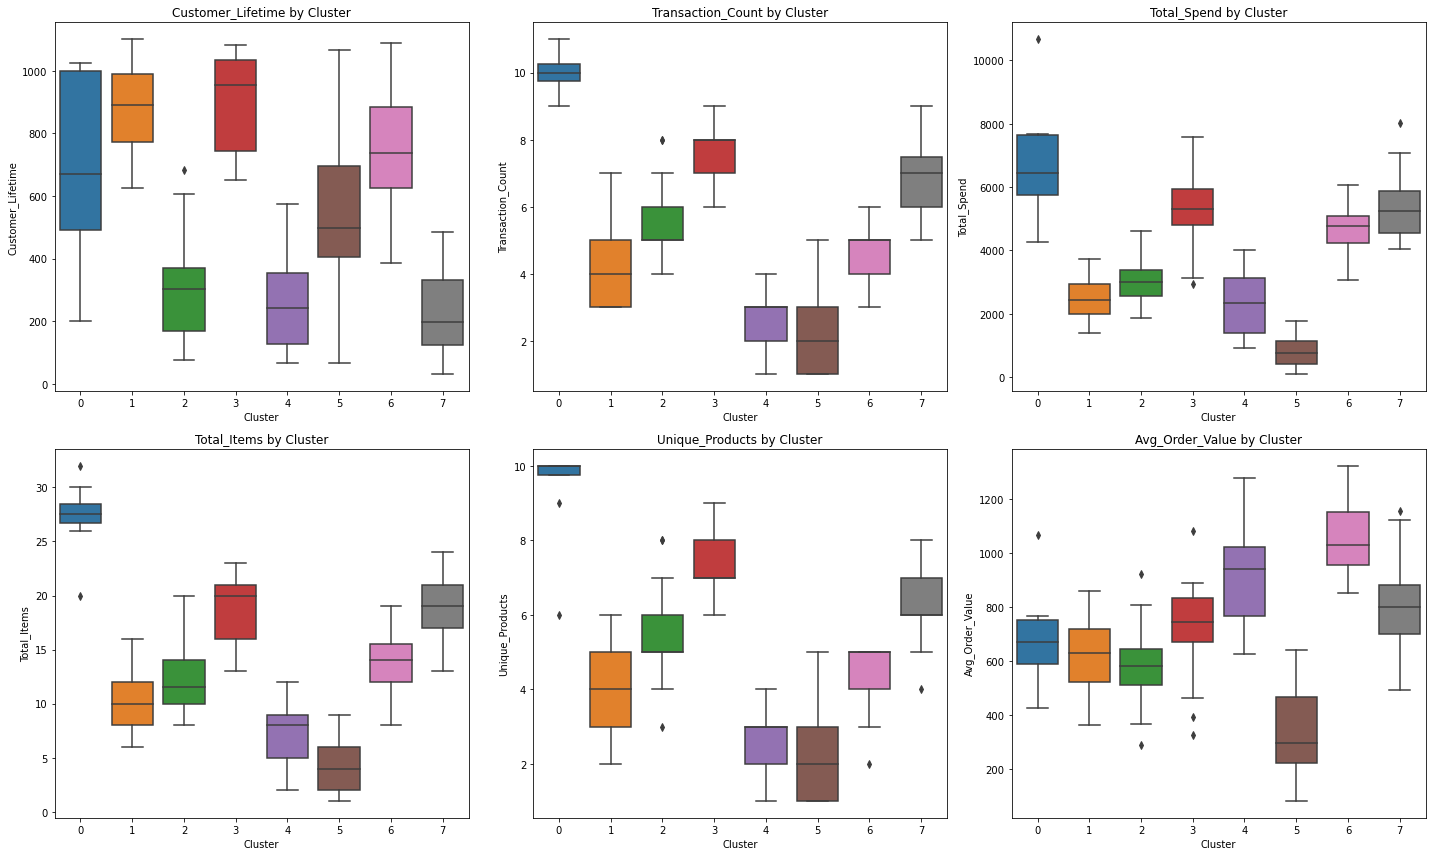

In [9]:
# Visualize results
customer_features = visualize_clusters(customer_features, labels, clustering_features)
    


In [10]:
# Generate report
generate_cluster_report(customer_features, final_db_score, final_silhouette_score)
    


Customer Segmentation Report

Number of Clusters: 8
Davies-Bouldin Index: 1.0562 (used for optimal cluster selection)
Silhouette Score: 0.2800 (for reference only)

Cluster Sizes:
0     8
1    42
2    40
3    25
4    21
5    21
6    15
7    27
Name: Cluster, dtype: int64

Cluster Profiles:
         Customer_Lifetime  Transaction_Count  Total_Spend  Total_Items  \
Cluster                                                                   
0                   685.50              10.00      6812.31        27.25   
1                   877.26               4.12      2488.40        10.10   
2                   300.42               5.32      3017.17        12.20   
3                   891.80               7.36      5262.18        18.48   
4                   252.52               2.52      2322.11         7.05   
5                   550.57               2.24       756.93         4.10   
6                   752.60               4.47      4670.41        13.53   
7                   232.37        